In [5]:
# %pip install ipynb
# %pip install face_recognition -i https://pypi.tuna.tsinghua.edu.cn/simple
# %pip uninstall opencv-python-headless -y 
# %pip install opencv-python --upgrade

In [6]:
# import notebook
from ipynb.fs.full.facial_similarity_checker import *
from ipynb.fs.full.image_landmark_extractor import *

# import the necessary packages
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [7]:
def set_transparent(image):
	tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
	_ , alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
	b, g, r = cv2.split(image)
	rgba = [b, g, r, alpha]
	image = cv2.merge(rgba, 4)
	
	return image

In [76]:
class ImageRegistrar:
    def __init__(self, landmark_extractor):
        self.landmark_extractor = landmark_extractor
        self.matched_landmarks = None

    def align_images(self, image, reference_image, show=False):
        # extract the landmarks from the input image and reference image
        facial_landmarks = self.landmark_extractor.get_landmarks(image, reference_image, show=show)

        aligned_image = self.__align_image(image, reference_image, matches=facial_landmarks)

        # save the matched landmarks
        self.matched_landmarks = facial_landmarks[1]

        return aligned_image

    def __align_image(self, image, reference_image, matches):
        ptsA = np.zeros((len(matches[0]), 2), dtype="float")
        ptsB = np.zeros((len(matches[1]), 2), dtype="float")
        ptsA = np.array(matches[0])
        ptsB = np.array(matches[1])

        # print(f"ptsA: {ptsA}")
        # print(f"ptsB: {ptsB}")

        # compute the homography matrix between the two sets of matched
        # points
        (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=5.0)
        # print(f"H: {H}")
        
        # use the homography matrix to align the images
        (h, w) = reference_image.shape[:2]
        aligned = cv2.warpPerspective(image, H, (w, h))
        
        return aligned
    
    def __generate_face_routes(self):
        routes = []
        landmark_tuple = self.matched_landmarks
        
        for i in range(15, -1, -1):
            from_coordinate = landmark_tuple[i+1]
            to_coordinate = landmark_tuple[i]
            routes.append(from_coordinate)
        
        from_coordinate = landmark_tuple[0]
        to_coordinate = landmark_tuple[17]
        routes.append(from_coordinate)
        
        for i in range(17, 20):
            from_coordinate = landmark_tuple[i]
            to_coordinate = landmark_tuple[i+1]
            routes.append(from_coordinate)
        
        from_coordinate = landmark_tuple[19]
        to_coordinate = landmark_tuple[24]
        routes.append(from_coordinate)
        
        for i in range(24, 26):
            from_coordinate = landmark_tuple[i]
            to_coordinate = landmark_tuple[i+1]
            routes.append(from_coordinate)
        
        from_coordinate = landmark_tuple[26]
        to_coordinate = landmark_tuple[16]
        routes.append(from_coordinate)
        routes.append(to_coordinate)

        return routes
    
    def extract_face(self, target_image, masked_image, with_line=False, show=False):
        if self.matched_landmarks is None:
            raise Exception("No matched landmarks found. Please call align_images first.")
 
        routes = self.__generate_face_routes()

        if (with_line):
            for i in range(0, len(routes)-1):
                from_coordinate = routes[i]
                to_coordinate = routes[i+1]
                masked_image = cv2.line(masked_image, from_coordinate, to_coordinate, (255, 255, 0), 1)
        
        mask = np.zeros((masked_image.shape[0], masked_image.shape[1]))
        mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
        mask = mask.astype(np.bool_)
 
        face_img = np.zeros_like(masked_image)
        face_img[mask] = masked_image[mask]
        
        # make background transparent
        face_img = set_transparent(face_img)

        if show:
            plt_imshow("Extracted Face", face_img)
        
        ## set target image to black (only mask part is extracted)
        # target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2RGBA)
        target_image[mask] = 255

        if show:
            plt_imshow("Target Image", target_image)
        
        return mask
    
    def merge_images(self, background, foreground, mask_idx, show_result=False):
        foreground_lab = cv2.cvtColor(foreground, cv2.COLOR_RGB2LAB)
        background_lab = cv2.cvtColor(background, cv2.COLOR_RGB2LAB)

        # Split the LAB images into individual channels
        foreground_l, foreground_a, foreground_b = cv2.split(foreground_lab)
        background_l, background_a, background_b = cv2.split(background_lab)
        
        # Perform histogram matching on the L channel of the foreground image
        foreground_l_matched = cv2.createCLAHE().apply(foreground_l)
        foreground_lab_matched = cv2.merge((foreground_l_matched, foreground_a, foreground_b))
        
        foreground_mean, foreground_std = cv2.meanStdDev(foreground_lab_matched)
        background_mean, background_std = cv2.meanStdDev(background_lab)
        
        # color_correction_matrix = background_std / foreground_std # * (foreground_lab - foreground_mean) + background_mean
        corrected_foreground_lab = foreground_lab.copy()
        # for i in range(3):
        #     corrected_foreground_lab = corrected_foreground_lab.astype('float64')
        #     corrected_foreground_lab[:, :, i] *=  color_correction_matrix[i]
        #     corrected_foreground_lab = corrected_foreground_lab.astype('uint8')
            
        corrected_foreground = cv2.cvtColor(corrected_foreground_lab, cv2.COLOR_LAB2BGR)
        
        # Create a mask of the foreground
        mask = np.zeros(foreground.shape[:2], np.uint8)
        mask[mask_idx] = 255
        
        # dilate the mask to smooth the edges
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (9,9))
        mask = cv2.dilate(mask, kernel, iterations=2)
        
        # Apply Gaussian blur to the mask
        mask_blurred = cv2.GaussianBlur(mask, (11, 11), 0)
        
        if show_result:
            plt_imshow("mask", mask_blurred)
            plt_imshow("corrected_foreground", corrected_foreground)
        
        feathered = cv2.cvtColor(mask_blurred, cv2.COLOR_GRAY2RGB).astype('float64')/255
        corrected_foreground = corrected_foreground.astype('float64')/255
        background = background.astype('float64')/255
        feathered = background * (1 - feathered) + corrected_foreground * feathered
        feathered = (feathered * 255).astype('uint8')

        merged_image = feathered

        if show_result:
            plt_imshow("Result", merged_image)
        
        return cv2.cvtColor(merged_image, cv2.COLOR_BGR2BGRA)

In [77]:
# construct the argument parser and parse the arguments
image_path = "test\\masked_girls.jpg"
target_path = "test\\target_img\\"

checker = facial_similarity_checker()
checker.load_image(image_path, target_path)
pairs = checker.check_similarity()

Test c:\Users\PC\Desktop\UST\Academic\2023-2024 Sping Sem\COMP4211 Machine Learning\Project\Mask-Removal-AI\test\target_img\
tar_list: ['test\\target_img\\target1.jpg', 'test\\target_img\\target2.jpg']


Action: race: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]  


{'x': 25, 'y': 105, 'w': 127, 'h': 164, 'left_eye': (121, 174), 'right_eye': (61, 170)}
{'x': 184, 'y': 197, 'w': 105, 'h': 137, 'left_eye': (259, 251), 'right_eye': (208, 245)}


Action: race: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]  


{'x': 67, 'y': 143, 'w': 133, 'h': 178, 'left_eye': (169, 227), 'right_eye': (107, 217)}
{'x': 229, 'y': 113, 'w': 126, 'h': 182, 'left_eye': (320, 190), 'right_eye': (262, 189)}


Action: race: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]  


{'x': 102, 'y': 127, 'w': 135, 'h': 177, 'left_eye': (201, 204), 'right_eye': (138, 208)}
{'x': 293, 'y': 177, 'w': 115, 'h': 166, 'left_eye': (367, 244), 'right_eye': (314, 245)}
masked - type:<class 'list'>
 ins: [['test\\masked_girls.jpg', facial area (x: 25 y: 105 Size: (127,164))], ['test\\masked_girls.jpg', facial area (x: 184 y: 197 Size: (105,137))]]
tar - type:<class 'numpy.ndarray'>
 ins: [['test\\target_img\\target1.jpg'
  facial area (x: 67 y: 143 Size: (133,178))]
 ['test\\target_img\\target1.jpg'
  facial area (x: 229 y: 113 Size: (126,182))]
 ['test\\target_img\\target2.jpg'
  facial area (x: 102 y: 127 Size: (135,177))]
 ['test\\target_img\\target2.jpg'
  facial area (x: 293 y: 177 Size: (115,166))]]
distance_matrix: [[0.62603697 0.8047857  0.65053117 0.85151802]
 [0.84145134 0.90433048 0.88945716 0.55869588]]


[[['test\\masked_girls.jpg', facial area (x: 184 y: 197 Size: (105,137))], array(['test\\target_img\\target2.jpg',
       facial area (x: 293 y: 177 Size: (115,166))], dtype=object)], [['test\\masked_girls.jpg', facial area (x: 25 y: 105 Size: (127,164))], array(['test\\target_img\\target1.jpg',
       facial area (x: 67 y: 143 Size: (133,178))], dtype=object)]]


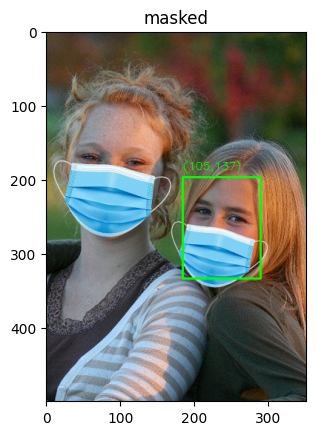

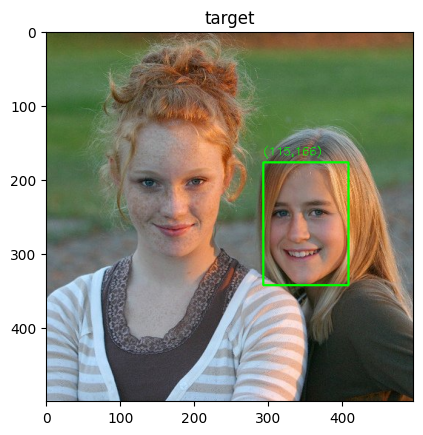

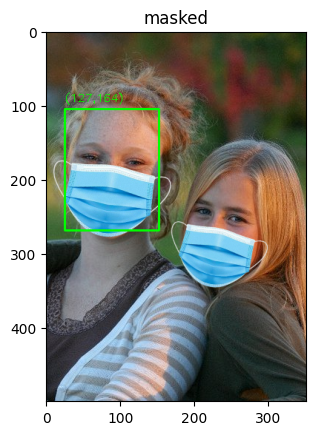

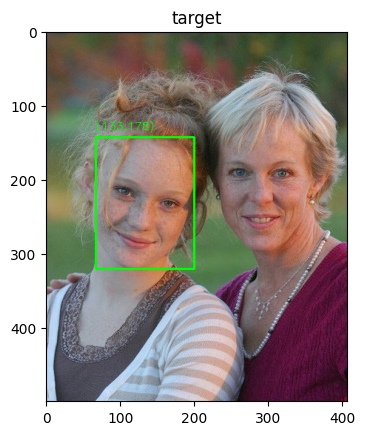

In [78]:
print(pairs)
for masked, target in pairs:
	plt_imshow("masked",masked[1].get_result(masked[0], with_size=True))
	plt_imshow("target",target[1].get_result(target[0], with_size=True))


[INFO] loading images...
[INFO] aligning images...
!! No face detected !!


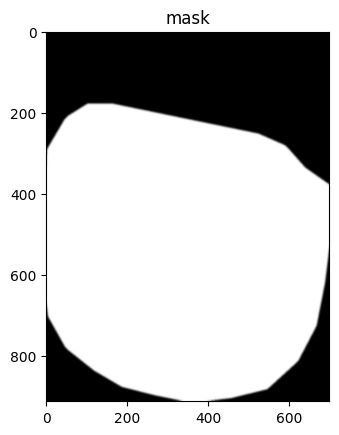

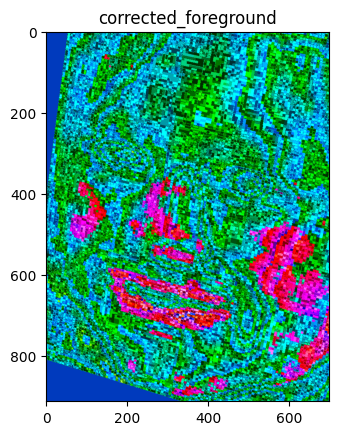

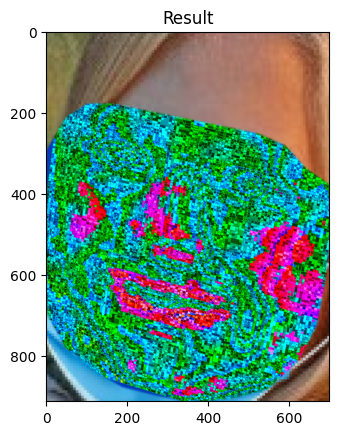

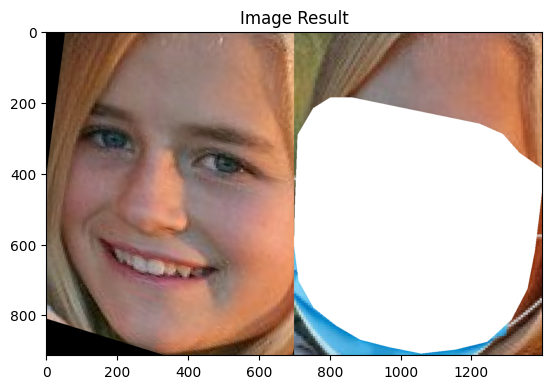

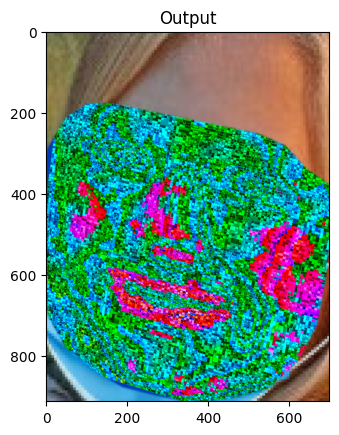

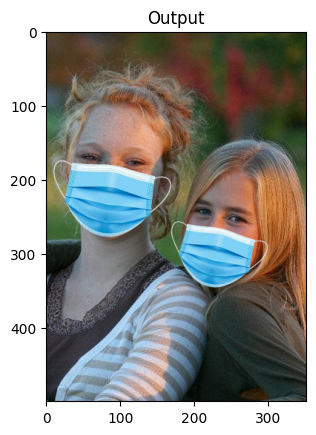

(500, 352, 3) (913, 700, 4)


ValueError: could not broadcast input array from shape (913,700,3) into shape (137,105,3)

In [79]:
output = cv2.imread(image_path)

for masked_image, target_image in pairs:
	# load the input image and template from disk
	print("[INFO] loading images...")
	image = cv2.imread(target_image[0])
	template = cv2.imread(masked_image[0])

	# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	# template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

	area1 = target_image[1]
	area2 = masked_image[1]

	image = image[area1.y:area1.y+area1.height, area1.x:area1.x+area1.width]
	template = template[area2.y:area2.y+area2.height, area2.x:area2.x+area2.width]

	# resize both the aligned and template images so we can easily
	# visualize them on our screen
	image = imutils.resize(image, width=700, height=700)
	template = imutils.resize(template, width=700, height=700)

	# align the images
	image_registrar = ImageRegistrar(LandmarkExtractor("shape_predictor_68_face_landmarks.dat"))

	print("[INFO] aligning images...")
	aligned = image_registrar.align_images(image, template, show=False)

	# our first output visualization of the image alignment will be a
	# side-by-side comparison of the output aligned image and the
	# template

	# our second image alignment visualization will be *overlaying* the
	# aligned image on the template, that way we can obtain an idea of
	# how good our image alignment is
	mask = image_registrar.extract_face(template, aligned, with_line=False, show=False)

	# plt_imshow("aligned", aligned)

	merged = image_registrar.merge_images(template, aligned, mask, show_result=True)

	stacked = np.hstack([aligned, template])

	# show the two output image alignment visualizations
	plt_imshow("Image Result", stacked)
	plt_imshow("Output", merged)

	# update the output image with the aligned image
	plt_imshow("Output", output)
	print(output.shape, merged.shape)
	output[area2.y:area2.y+area2.height, area2.x:area2.x+area2.width] = cv2.cvtColor(merged, cv2.COLOR_RGBA2RGB)	

# final output
plt_imshow("Final Output", output)	
